In [1]:
import gymnasium as gym
import bam_gym # you need to import to register
from bam_gym.utils import SampleSaver

import torch
import json

In [2]:
n_arms = 10
n_state = 1
env = gym.make("bam/ContextBandit", n_arms=n_arms, n_state=n_state, seed=1)

In [20]:
saver = SampleSaver("/home/bam/other_bam_packages/bam_gym/dataset",
                 "ContextBandit",
                 "GPU"
                 )

[SampleSaver] Resuming from /home/bam/other_bam_packages/bam_gym/dataset/ContextBandit/GPU/sarsa_0000.jsonl
[SampleSaver] Current counter: 0, current json count: 0


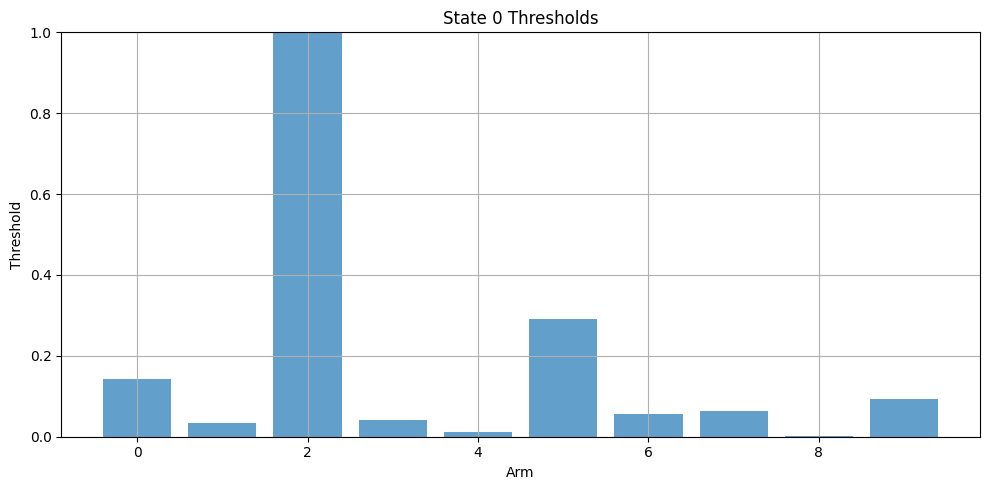

In [4]:
observation, info = env.reset()
env.render()


In [81]:
action = env.action_space.sample()

next_observation, reward, terminated, truncated, next_info = env.step(action)

print(f"\nStep Result:")
print(f"Observation: {observation}")
# print(f"Observation: (shape={observation.shape}, dtype={observation.dtype})")
print(f"Action: {action}")
print(f"Reward: {reward}")
print(f"Terminated: {terminated}")
print(f"Truncated: {truncated}")
print(f"Next Observation: {next_observation}")


Step Result:
Observation: 0
Action: 7
Reward: -1
Terminated: True
Truncated: False
Next Observation: 0


In [23]:
for _ in range(1000):
    # action = policy(observation)
    action = env.action_space.sample()

    next_observation, reward, terminated, truncated, next_info = env.step(action)
    saver.save_sample(observation, action, reward, terminated, truncated, info)

    observation = next_observation
    info = next_info

    # Env Auto resets so not needed
    # if (terminated or truncated):
    #     observation, info = env.reset()

env.close()
saver.close()


[SampleSaver] Finished saving 3000 samples.


In [24]:
dataset = []
with open('/home/bam/other_bam_packages/bam_gym/dataset/ContextBandit/GPU/sarsa_0000.jsonl', 'r') as f:
    for line in f:
        dataset.append(json.loads(line))


print(f"Loaded {len(dataset)} samples.")
print(dataset[0])

Loaded 3000 samples.
{'#': 0, 's': {'obs': 0}, 'a': 7, 'r': -1}


In [390]:
# Counting Solution
n_arms = 10
n_state = 1

reward_sum = torch.zeros((n_state, n_arms), dtype=torch.float32)
action_count = torch.zeros((n_state, n_arms), dtype=torch.float32)

for entry in dataset:
    state = entry['s']['obs']   # Assuming 'obs' is an integer state ID
    action = entry['a']
    reward = entry['r']

    reward_sum[state, action] += reward
    action_count[state, action] += 1

# Avoid division by zero
avg_reward = torch.where(
    action_count > 0,
    reward_sum / action_count,
    torch.zeros_like(reward_sum)
)

print("\nReward Sum Matrix:")
print(reward_sum)

print("\nAverage Reward Matrix:")
print(avg_reward)

# Find best action per state
for state in range(n_state):
    best_action = torch.argmax(avg_reward[state]).item()
    best_reward = avg_reward[state, best_action]
    print(f"State {state}: Best action is {best_action} with estimated average reward {best_reward:.2f}")


Reward Sum Matrix:
tensor([[-196., -280.,  307., -277., -263., -126., -253., -300., -275., -261.]])

Average Reward Matrix:
tensor([[-0.6901, -0.9459,  1.0000, -0.9585, -0.9634, -0.3962, -0.8576, -0.9036,
         -0.9786, -0.8031]])
State 0: Best action is 2 with estimated average reward 1.00


In [25]:
import torch
import torch.nn as nn
import torch.optim as optim

See https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html

In [26]:

class SimpleFCN(nn.Module):
    def __init__(self, n_states, n_actions):
        super().__init__()

        # One-hot input → output actions
        self.fc = nn.Linear(n_states, n_actions, bias=False)  # no bias to match pure s x n weight

    def forward(self, state_index):
        # Convert state index to one-hot
        one_hot = torch.nn.functional.one_hot(state_index, num_classes=self.fc.in_features).float()
        output = self.fc(one_hot)
        return output

In [438]:
model = SimpleFCN(n_state, n_arms)
optimizer = optim.SGD(model.parameters(), lr=1e-1)


In [396]:
print(model.fc.weight.data)


tensor([[ 0.6086],
        [ 0.4732],
        [ 0.0038],
        [-0.9866],
        [-0.4658],
        [-0.5126],
        [ 0.8697],
        [ 0.4146],
        [ 0.0470],
        [-0.5620]])


In [497]:
for i in range(1000):
    batch_size = 500


    shuffled_indices = torch.randperm(len(dataset))

    for start_idx in range(0, len(dataset), batch_size):
        batch_indices = shuffled_indices[start_idx:start_idx + batch_size]
        batch = [dataset[i] for i in batch_indices]

        # Extract tensors
        states = torch.tensor([b['s']['obs'] for b in batch], dtype=torch.long)
        actions = torch.tensor([b['a'] for b in batch], dtype=torch.long)
        rewards = torch.tensor([b['r'] for b in batch], dtype=torch.float32)
        # print(actions)
        # print(rewards)
        # Forward pass
        logits = model(states)  # (batch_size, n_actions)
        # print(logits)
        log_probs = torch.nn.functional.log_softmax(logits, dim=-1)

        # Get the log-probability of the action taken
        selected_log_probs = log_probs[torch.arange(len(batch)), actions]
        # print("log_probs: ", log_probs)
        # print("action_log_prob: ", selected_log_probs)
        # Policy Gradient Loss
        loss = -(selected_log_probs * rewards).mean()

        # Backpropagation
        print(model.fc.weight.data)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(model.fc.weight.data)

        print(f"Loss: {loss:.4f}")
        break


tensor([[-40.2931],
        [-55.3421],
        [444.5466],
        [-54.1975],
        [-52.0172],
        [-25.3146],
        [-50.6173],
        [-60.2995],
        [-55.4821],
        [-53.2059]])
tensor([[-40.2999],
        [-55.3521],
        [444.6178],
        [-54.2067],
        [-52.0256],
        [-25.3184],
        [-50.6241],
        [-60.3087],
        [-55.4919],
        [-53.2131]])
Loss: -353.3665
tensor([[-40.2999],
        [-55.3521],
        [444.6178],
        [-54.2067],
        [-52.0256],
        [-25.3184],
        [-50.6241],
        [-60.3087],
        [-55.4919],
        [-53.2131]])
tensor([[-40.3061],
        [-55.3615],
        [444.6928],
        [-54.2147],
        [-52.0334],
        [-25.3252],
        [-50.6319],
        [-60.3199],
        [-55.5005],
        [-53.2223]])
Loss: -371.6524
tensor([[-40.3061],
        [-55.3615],
        [444.6928],
        [-54.2147],
        [-52.0334],
        [-25.3252],
        [-50.6319],
        [-60.3199],
    

Nice ok its working... every single time there are always more considerations. In this case the weights were updating correctly in the right direction, but I just needed to run it for longer.

- Using a larger batch size was important. To get a better estimate for the gradient. otherwise when you penalize one thing you increase the others, when in reality they shouldn't be increased! 
- There is already enough noise... I think you want a more accurate approx of gradient
- 

In [389]:
batch_size = 500


shuffled_indices = torch.randperm(len(dataset))

for start_idx in range(0, len(dataset), batch_size):
    batch_indices = shuffled_indices[start_idx:start_idx + batch_size]
    batch = [dataset[i] for i in batch_indices]

    # Extract tensors
    states = torch.tensor([b['s']['obs'] for b in batch], dtype=torch.long)
    actions = torch.tensor([b['a'] for b in batch], dtype=torch.long)
    rewards = torch.tensor([b['r'] for b in batch], dtype=torch.float32)

    # Forward pass
    logits = model(states)  # (batch_size, n_actions)
    log_probs = torch.nn.functional.log_softmax(logits, dim=-1)

    # Get the log-probability of the action taken
    selected_log_probs = log_probs[torch.arange(len(batch)), actions]

    # Policy Gradient Loss
    loss = -(selected_log_probs * rewards).mean()

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Loss: {loss:.4f}")


Loss: -1.5426
Loss: -1.6344
Loss: -1.5398
Loss: -1.6043
Loss: -1.5595
Loss: -1.5288


In [10]:
num_actions = 10  # assuming actions are between 0 and 9
reward_sum = torch.zeros(num_actions, dtype=torch.float32)
action_count = torch.zeros(num_actions, dtype=torch.float32)

In [11]:
for entry in dataset:
    action = entry['a']
    reward = entry['r']
    reward_sum[action] += reward
    action_count[action] += 1

In [13]:
avg_reward = torch.where(
    action_count > 0,
    reward_sum / action_count,
    torch.zeros_like(reward_sum)
)

In [15]:
print(reward_sum)
print(avg_reward)

best_action = torch.argmax(avg_reward).item()
print(f"\nBest action is {best_action} with estimated average reward {avg_reward[best_action]:.2f}")


tensor([ -70., -104.,   92., -106.,  -93.,  -28.,  -95.,  -87., -107.,  -82.])
tensor([-0.7778, -0.9630,  1.0000, -0.8983, -0.9588, -0.2917, -0.8879, -0.9355,
        -1.0000, -0.8913])

Best action is 2 with estimated average reward 1.00


In [ ]:
# Create a table
# Accumlate the reward for each action
# divide by the number of times I tried it
# this will estimate the return for each one